## First run this code to add some style to your notebook!

In [6]:
from IPython.core.display import HTML
import os
def css_styling():
    """Load default custom.css file from ipython profile"""
    base = os.getcwd()
    styles = "<style>\n%s\n</style>" % (open(os.path.join(base,'files/custom.css'),'r').read())
    return HTML(styles)
css_styling()

# 3 Molecular Library Screening with RDKit!

[![RDKIT](http://www.rdkit.org/Images/logo.png)](http://www.rdkit.org/)

#### Idea:
In this iPython notebook you'll get a sense of what it's like to generate and run calculations on a larger scale molecular library.  Molecular libraries have been (are being) used (in our group and others) to screen for molecules with promising properties in the fields of organic photovoltacis, organic LED's, flow batteries, among many others. 

We'll pretend that we're building and screening a library of organic molecules for photovoltaics applications.  Once we have some electronic structure properties of the molecules (specifically, estimates for the HOMO and LUMO energies), we'll use a simple model called the Scharber Model to predict the Energy Conversion efficiency that we'd obtain if we used these molecules as donor molecules in an organic solar cell. 

**NOTE:** The purpose of the notebook is just to give you a feel for large scale molecular screening.  Since we'll be running many calculations in your laptop's virtual machine, we'll have to use relatively cheap and fast methods called Semi-Empirical methods. **So don't trust the values that we predict too much...**

## First, we'll import rdkit and PyQuante

In [10]:
#import sys
#sys.path.append('/usr/lib/python2.7/dist-packages/')
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem import PyMol

from PyQuante.Molecule import Molecule
from PyQuante import SCF

In [9]:
# more imports
from scipy.integrate import simps
import numpy as np # Numpy import
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

### Auxilary Function

In [11]:
from PyQuante.Constants import ang2bohr
import imolecule

def visualize_Mol(molecule):
    mol = molecule.copy()
    # convert angstrom to bohr
    for atom in mol:
        coords=[a/ ang2bohr for a in atom.pos()]
        atom.update_coords(coords)
    # create as xyz string
    xyz_str = mol.as_string()
    return imolecule.draw(xyz_str,format='xyz',shader="phong")

## Defining reactions and fragments:

The first step to start using rdkit to make our molecular library is to define the types of "reactions" that are allowed.  Without going into too much detail, the two lines below define two different types of reactions: **fusion** and **linking**.  You'll get a sense of what they mean further down. 

In [12]:
linking_reaction = AllChem.ReactionFromSmarts('[cH1,nH1:1].[cH1:2]>>[*:1]-[*:2]')
fusion_reaction = AllChem.ReactionFromSmarts('[a:7]~1~[a:8]~[a:9]~[cH:1][cH:2]~[a:10]~1.[a:5][c;H1:3][c;H1:4][a:6]>>[*:7]~1~[*:8]~[*:9]~[*:1](:[*:5])~[*:2](:[*:6])~[*:10]~1.[*:3][*:4]')

Next, we'll define the set of fragments from which we'll build our entire molecular library. The fragments are defined in a string format that is now as the SMILES string format.  **SMILES** stands for simplified molecular-input line-entry system.

You can read up on the specifics of the syntax in the [webs](http://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system).

In [14]:
#This is the list of fragments, in SMILES format,  that we'll be working with: 
fragments = ["C1=CC=CC=C1","C1=CC=NC=C1","N1=CC=NC=C1","N1C=CC=C1","O1C=CC=C1"]

Ok, so now we have those fragments.... but what do they look like? 

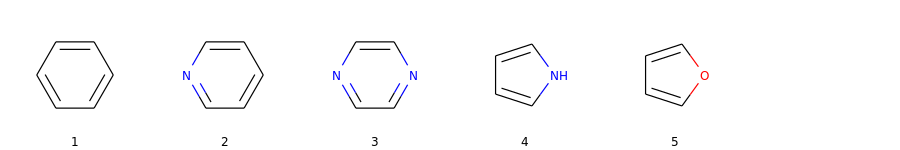

In [15]:
reactants = [AllChem.MolFromSmiles(i) for i in fragments]
Draw.MolsToGridImage(reactants, legends = [str(i+1) for i in range(6)], molsPerRow = 6, subImgSize=(150,150))    

### Do you recognize them? 
0. Benzene
1. Pyridine
2. Pyrazine
3. Pyrrole
4. Furan

## Building the 1st generation library 
As a next step, we'll start "mating" these fragments, in order to generate molecules that are composed of pairs of fragments.  These pairs can either be "linked" or they can be "fused"

### I'll first show you what I want you to do for a single pair of fragments:

In [16]:
products = set() #start with an empty set
#get a single pair of fragments
r1 = reactants[0]
r2 = reactants[1]
#React them
prods = linking_reaction.RunReactants((r1, r2))
#Store all the products, in smiles format, in the products set
for prod in prods:
    product_SMILES = AllChem.MolToSmiles(prod[0])
    products.add(product_SMILES)

In [17]:
print products

set(['c1ccc(-c2ccccn2)cc1', 'c1ccc(-c2cccnc2)cc1', 'c1ccc(-c2ccncc2)cc1'])


### Here is where the fun starts.  
Write two nested for-loops:
* #### The first nested for-loop will react all pairs of fragments using the linking reaction. 
* #### The second nested for-loop will react all pairs of fragments using the fusion reactions. 

At the end of each nested for-loop, store the products in the products set! 

In [18]:
#############

products = []

#Linking reactions:
for r1 in reactants:
    for r2 in reactants:
        for prod in linking_reaction.RunReactants((r1, r2)):
            product_SMILES = AllChem.MolToSmiles(prod[0])
            products.append(product_SMILES)

#Fusion reactions:
for r1 in reactants:
    for r2 in reactants:
        for prod in fusion_reaction.RunReactants((r1, r2)):
            product_SMILES = AllChem.MolToSmiles(prod[0])
            products.append(product_SMILES)
            
###############
# get ony unique values
products = set(products)

In [19]:
print 'the total number of 1st generation molecules is ---> ', len(products)

the total number of 1st generation molecules is --->  87


### Let's look a the products
The products are smiles strings (you can verify by printing products).
We want to see what they look like, so we'll convert the smiles to rdkit molecules. 

In [20]:
gen1 = [AllChem.MolFromSmiles(i) for i in products]

Now let's see what our first generation library looks like: 

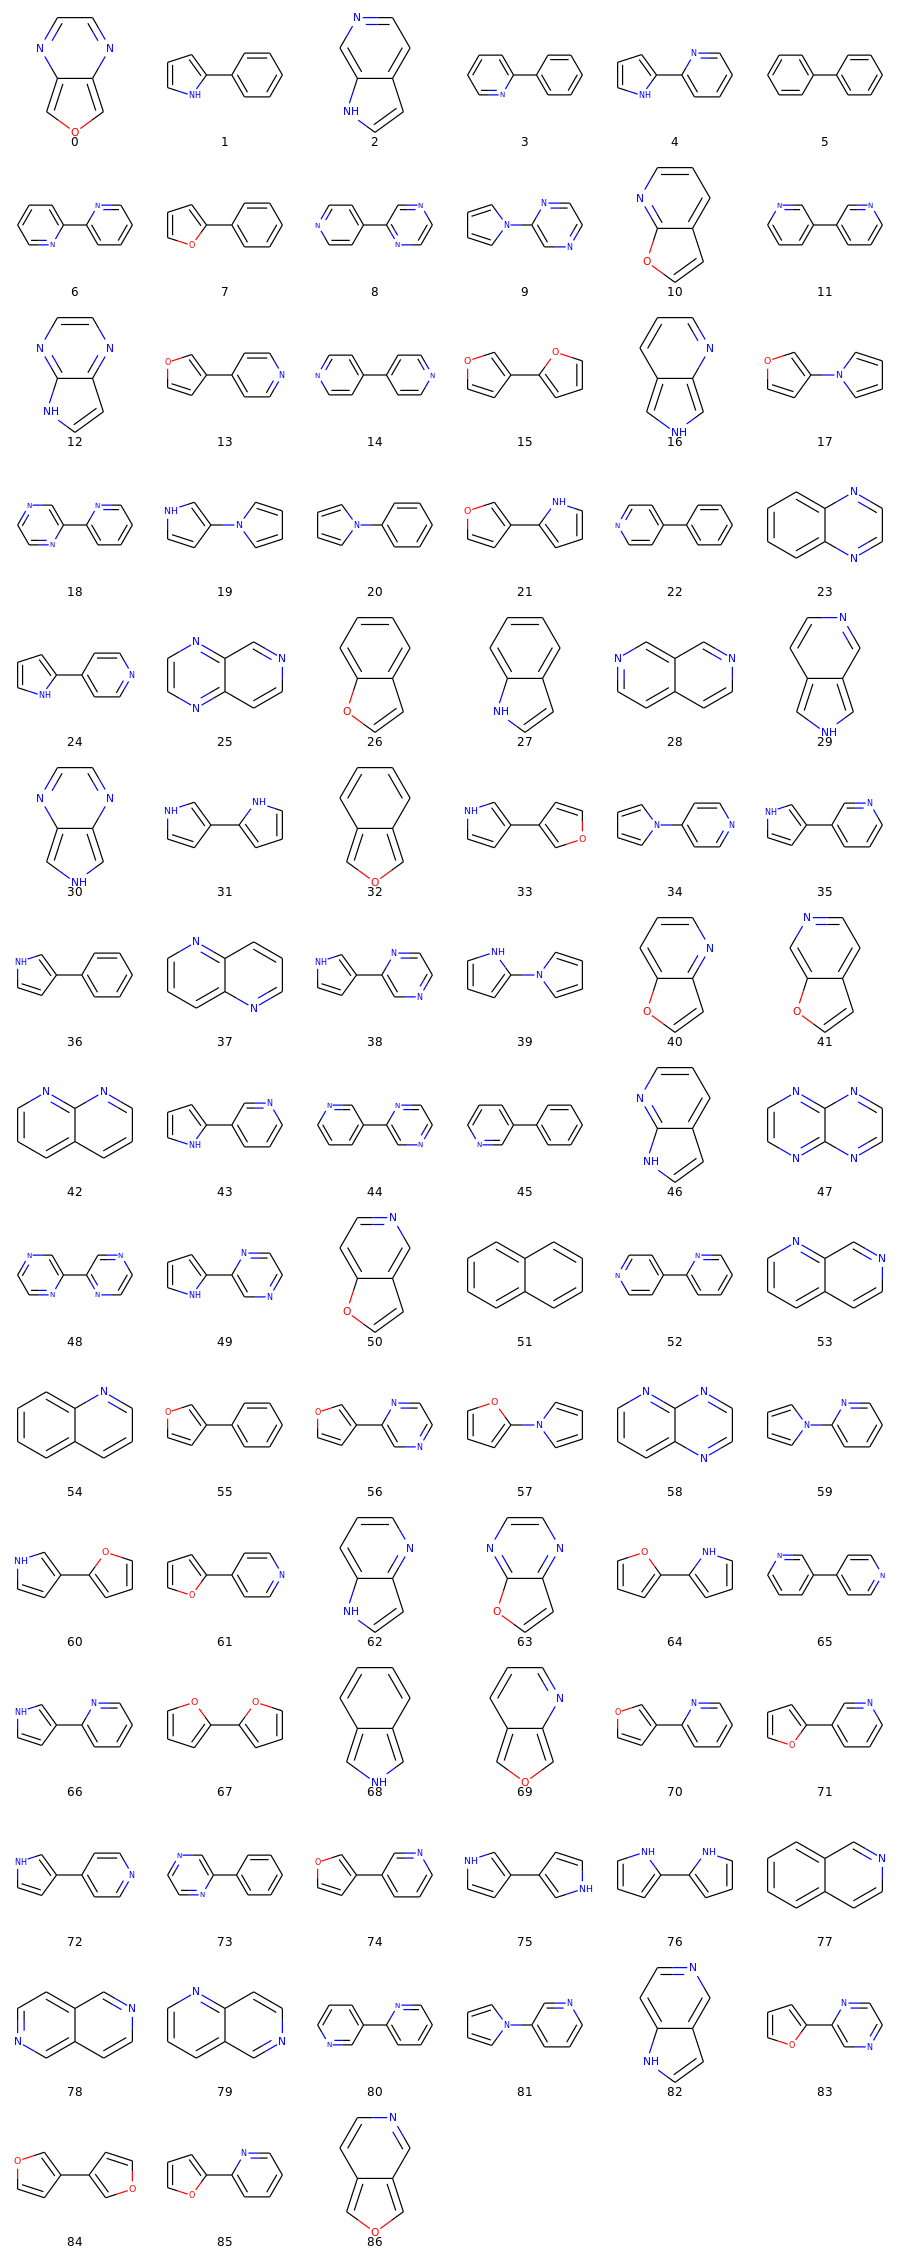

In [21]:
Draw.MolsToGridImage(gen1, legends = [str(i) for i in range(len(gen1))], molsPerRow = 6, subImgSize=(150,150))

One happy family!
## Second generation Library:

Let's take it to the next step! Let's take all the molecules in the list of two-fragment products, and "react" them again with the set of fragments in order to generate a library of three-fragment products. 

### Write again two nested for-loops  
* The first nested for-loop will react all molecules in reactants with all of the fragments using the linking reaction. 
* The second nested for-loop will react all molecules in reactants with all of the fragments using the fusion reaction.

Keep adding the resulting molecules to the set products

#### **NOTE:** since we want to mix all the 1st generation products with the fragments, one for-loop should loop over reactants, while the other should loop over gen1!

In [22]:
#First for loop: linking reactions
products = []

for r1 in reactants:
    for r3 in gen1:
        for prod in linking_reaction.RunReactants((r1, r3)):
            product_SMILES = AllChem.MolToSmiles(prod[0])
            products.append(product_SMILES)

#Second nested for-loops: fusion reactions. 
for r1 in reactants:
    for r3 in gen1:
        for prod in fusion_reaction.RunReactants((r1, r3)):
            product_SMILES = AllChem.MolToSmiles(prod[0])
            products.append(product_SMILES)

products = set(products)

How many molecules are there in this second generation library?  

In [23]:
print 'the total number of second generation molecules is --> ', len(products)

the total number of second generation molecules is -->  3500


These are way too many molecules to display in our iPython notebook, so in order to visualize them, we'll take a random subset of them, of size 200. 

In [24]:
import random
random_ind = random.sample(range(len(products)), 200)

And we'll visualize those:

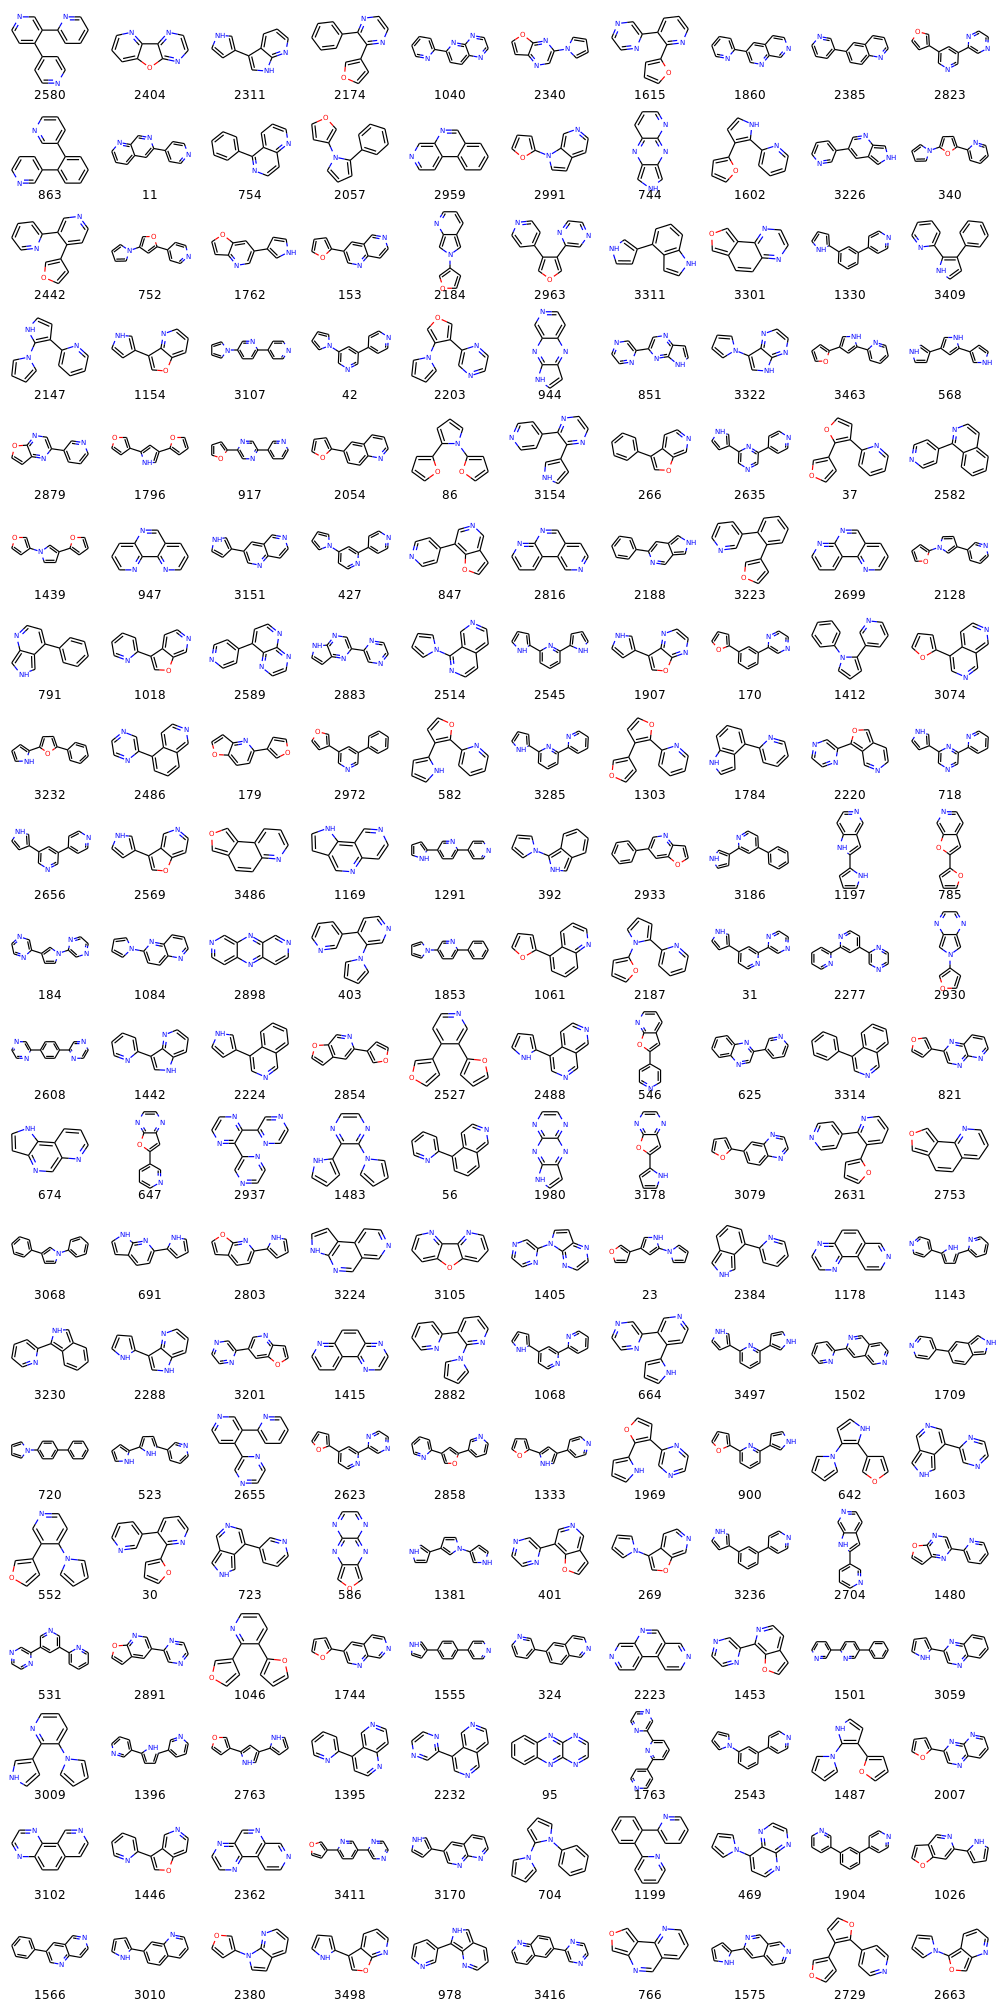

In [26]:
mList = []
products = list(products)
for ind in random_ind:
    m = Chem.MolFromSmiles(products[ind],sanitize=False)
    m.UpdatePropertyCache()
    mList.append(m)

Draw.MolsToGridImage(mList, legends = [str(i) for i in random_ind], molsPerRow = 10, subImgSize=(100,100))

## Baby Step: For a single molecule:

1. Convert the rdkit molecule to a PyQuante molecule
2. Perform a cheap electronic structure calculation 
3. Get the estimates for the HOMO energy and the LUMO energy

Next we'll run the three steps above for a single molecule. Let's pick molecule number 3433:

### 1. Convert rdkit molecule to a PyQuante molecule

In [27]:
#Convert SMILES to rdkit molecule
m = Chem.MolFromSmiles(products[3433])
#Add all the hydrogen atoms: 
m2=Chem.AddHs(m)

In [28]:
#Get the coordinates of the atoms in 3D space. 
AllChem.EmbedMolecule(m2)
AllChem.UFFOptimizeMolecule(m2)
confo1 = m2.GetConformer()
coordList = [] #and empty list, where we'll add all the coordinates and atom types
for i, atom in enumerate( m2.GetAtoms() ):
    coord = confo1.GetAtomPosition(i)
    coordList.append((atom.GetAtomicNum(), (coord.x, coord.y, coord.z)))

#### Now we're ready to create a PyQuante molecule object which we know and love. 

In [29]:
molTest=Molecule('CEPTest',
             atomlist = coordList, units = 'Angstroms')

And let's visualize the 3D structure!

In [30]:
visualize_Mol(molTest)

### 3. Perform an Electronic Structure Calculation with the MINDO/3 SemiEmpirical Method
Since we are going to have to run a TON of electronic structure calculations, and we are doing this in our little virtual machines, we can't really afford to run a ton of Hartree-Fock or DFT calculations.  (Although you may want to try it if you're really brave and want to see how well your laptop performs!!!)

Remember MINDO/3 is a semi-empirical method! Keep that in mind when we produce predictions in this exercise.

In the real world of Quantum Chemistry Research, you would want to have access to a huge cluster which would let you run methods such as **MP2**, **DFT**, or even **Linear Scaling Coupled Cluster Methods** on the huge set of molecules, in order to make sure that your predictions are extremely accurate.  

We can do this in two lines of code:

In [31]:
mol_mindo3 = SCF(molTest, method='MINDO3')
mol_mindo3.iterate(maxiter = 100)

## 3. Get HOMO and LUMO Energies

$$ E_{gap} =E_{LUMO} - E_{HOMO} \quad (band\; gap)$$

To get the **HOMO** and **LUMO** energies, we just have to figure out how many orbitals are occupied (closed) and the take the energy of the Highest Occupied molecular orbital. 

In [32]:
nclosed = mol_mindo3.nclosed
donor_HOMOh = mol_mindo3.orbe[nclosed - 1]

To get the **LUMO** energy, we get the energy of the next one up!

In [33]:
fudge_factor = 5
donor_LUMOh = mol_mindo3.orbe[nclosed] - fudge_factor

#### Did you notice that mysterious variable called the fudge_factor?
Basically, we're shifting the the LUMO energy down by that fudge factor, many times calcualtions will not compare directly with experiment so it is nesesary to introduce a calibration in order to give predictive power to calculations.

This is where the **''fudge factor''** comes in..  That's how crappy the semi-empirical methods perform for this particular application.

But nevermind, the point is to get a feel for high-throughput, large scale quantum chemistry calculations for molecular screening. 

In [34]:
print donor_HOMOh
print donor_LUMOh
gap = donor_LUMOh - donor_HOMOh
print 'the HOMO-LUMO gap, in wavelength (nanometers), is ----> ',1239.84187/gap, 'nm'

-7.87547283148
-4.37693066721
the HOMO-LUMO gap, in wavelength (nanometers), is ---->  354.38814563 nm


### Question:  What color of light does that correspond to? 

## Making prections with the Scharber Model 

We can use the Scharber Model to predict the solar cell conversion efficiency if we were to use that molecule as an electron donor in an organic solar cell. 

In order to predict the energy conversion efficiency, we need the solar spectrum. Specifically, we want to rate at which energy from the sun hits the surface of the earth as a function of wavelength. 

### Read a file that has the solar spectrum data in it. 

Don't worry to much about the code, we just want to load the data in to some arrays

In [38]:
df=pd.io.parsers.read_csv('files/AM15_PhotFlux_rev.csv')

wavelength = df['Wavelength (nm)']
power = df[' Global Tilt (W m-2 nm-1)']
flux = df[' Flux (W m-2)']

What does this file look like? (Just a comma seperated value **csv**)

In [50]:
!head files/AM15_PhotFlux_rev.csv

### Exercise: Let's plot the beautiful solar spectrum.
When you look at it, remember in awe that we all come from the stardust...

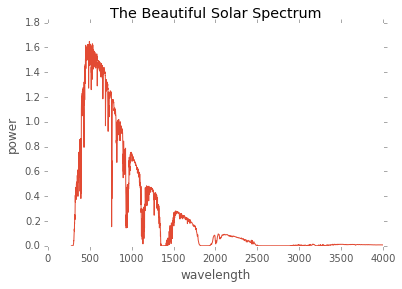

In [51]:
##### plot code here ##########
plt.plot(wavelength, power)
plt.xlabel('wavelength')
plt.ylabel('power')
plt.title('The Beautiful Solar Spectrum')
plt.show()

### Putting it all together: Scharber model
Now we'll define a function that, given the **HOMO**,** LUMO**, **power spectrum** (power and wavelength), returns the predicted **Power Conversion Efficiency** (PCE) via the Scharber model. 

Although the Scharber model is pretty straightforward, and can be thought of as a specialized version of the Shockley-Queisser model, it is beyond the scope of this iPython notebook to delve into the derivaition.  so lets just use it as a blackbox function. 

In [52]:
def ScharberEfficiency(donorHOMO, donorLUMO, power, wavelength):
    fullPower = simps(power, wavelength)
    #This is the LUMO energy, in eV, of the acceptor molecule, PCBM.
    pcbm_l=-4.3
    
    # This is the open circuit voltage
    voc=abs(donorHOMO)-abs(pcbm_l)-0.3

    #This is the bandgap, in nano-meters, band gap
    bandgap_ev=abs(donorLUMO-donorHOMO)
    bandgap=1239.84187/bandgap_ev 
    
    wavelength_range=[]
    power_range=[]
    flux_range=[]

    #determine what we will integrate --> only those wavelengths of the solar spectrum shorter than the band gap wavelength
    for i in range(len(wavelength)):  
        if wavelength[i]<bandgap: #we'll integrate all wavelengths that are shorter than the band gap. 
            wavelength_range.append(wavelength[i])
            flux_range.append(flux[i])
        else:
            break

            
    #This is the short circuit current
    jsc=simps(flux_range, wavelength_range)
    #This is called the Fill Factor
    jsc=jsc*0.65 # Take away 0.65 for 26%
    
    #Finally, this is the efficiency
    pce=100*voc*jsc/fullPower # Take away 0.65 for 17% 
    
    return pce

In [53]:
pce = ScharberEfficiency(donor_HOMOh, donor_LUMOh, power, wavelength)
print 'The Power Conversion Efficiency is ---->', pce, '%'

The Power Conversion Efficiency is ----> 0.920600572947 %


## Let the Molecular Screening Begin!
### Now, show us what you've learned in this course by repeating all the steps we did above but for a random set of N molecules!!  YEAH!!!!!

But first, make use of good programming practices by wrapping each module/step of what we've done above in a set of little functions. 

Note that we have worked out above all the pieces of the puzzle above!

### Get conformer coordinates from rdkit molecule:

Write a function called rdkit_to_PyQuante which takes as input a molecule in smiles format and returns a PyQuante molecule

In [60]:
def rdkit_to_PyQuante(mol_smiles):
    ###########################################################
    #Convert SMILES to rdkit molecule
    m = Chem.MolFromSmiles(mol_smiles)
    
    #Get conformer from rdkit
    m2=Chem.AddHs(m)
    AllChem.EmbedMolecule(m2)
    AllChem.UFFOptimizeMolecule(m2)
    confo1 = m2.GetConformer()
    
    #Get coordinates
    coordList = []
    for i, atom in enumerate( m2.GetAtoms() ):
        coord = confo1.GetAtomPosition(i)
        coordList.append((atom.GetAtomicNum(), (coord.x, coord.y, coord.z)))
        
    #Create the PyQuante Molecule
    molTest=Molecule('CEPTest',
             atomlist = coordList, units = 'Angstroms') 
    
    ###############################################################
    return molTest 

### run MINDO/3 electronic structure calculation

write a function called mindo3_calc which takes as input a PyQuante molecule, and returns the molecule object that results from performing the SCF iterations. 

In [61]:
def mindo3_calc(molecule):
    ##################################################
    mol_mindo3 = SCF(molTest,method="MINDO3")
    mol_mindo3.iterate(maxiter = 200)
    ##################################################
    return mol_mindo3

### Get HOMO and LUMO energies

write a function called getHOMO_LUMO which takes as input the output of mindo3_calc, and returns the HOMO and LUMO energies. 

In [62]:
def getHOMO_LUMO(molecule_mindo3):
    #########################################################
    nclosed = molecule_mindo3.nclosed
    donor_HOMOh = molecule_mindo3.orbe[nclosed - 1]
    gap = donor_LUMOh - donor_HOMOh
    #######################################################
    return (donor_HOMOh, donor_LUMOh)

## Get the PCE for a random subset of N  molecules, storing it in an array!

Now generate a random set of indices between 0 and (len(products) - 1).  That's the library that you'll analyze!

In [63]:
N = 100
random.seed()
rand_ind = random.sample( range(len(products)), N )
print rand_ind

[2368, 1897, 889, 3016, 831, 307, 1732, 2332, 749, 3390, 2748, 2338, 2282, 1400, 1388, 373, 621, 1996, 841, 1079, 228, 796, 781, 2389, 3370, 2684, 1470, 1746, 1, 2500, 739, 2550, 2959, 1578, 1524, 2808, 2558, 2050, 64, 443, 2757, 1937, 453, 182, 1129, 1950, 1840, 2882, 43, 2608, 1280, 1813, 941, 492, 2346, 1398, 1409, 2637, 3497, 119, 3130, 19, 744, 2717, 2008, 634, 636, 1930, 1220, 256, 1275, 816, 488, 2054, 1882, 1499, 310, 2243, 2533, 1534, 1805, 736, 2378, 2201, 283, 162, 2175, 2800, 2832, 3467, 1176, 2455, 221, 1281, 1216, 189, 212, 1380, 2534, 1103]


Using the functions you defined above, get the Power Conversion Efficiency (PCE) of every molecule in your subset, and stores it in a pce_array of the appropriate size. 

In [64]:
i = 0
pce_array = np.zeros(len(rand_ind))
for ind in rand_ind:
    ########################################################
    #generate PyQuante molecules
    molTest = rdkit_to_PyQuante(products[ind]) 
    
    #run MINDO/3 electronic structure calculation
    mol_mindo3 = mindo3_calc(molTest)
    
    #Get the HOMO and LUMO energies
    HOMO, LUMO = getHOMO_LUMO(mol_mindo3)
    
    #Estimate the power conversion efficiency
    pce = ScharberEfficiency(HOMO, LUMO, power, wavelength)
    ########################################################
    
    pce_array[i] = pce
    i+=1
    print ind, pce

2368 0.652083584109
1897 0.292317781784
889 1.18438921427
3016 6.25689022773
831 2.37077242477
307 3.65829597125
1732 3.52142067598
2332 8.80716705049
749 3.52442600974
3390 0.861364758244
2748 4.16607886272
2338 3.39422471569
2282 1.64929326458
1400 7.03389813166
1388 1.66563821681
373 1.64861194305
621 1.13834471106
1996

 0.463478965003
841 0.705541945917
1079 1.98087464266
228 1.93279084846
796 0.799685766559
781 3.39322714162
2389 1.42296275325
3370 4.9247727728
2684 9.88046729953
1470 3.01653503042
1746 4.72775322524
1 2.01510017511
2500 2.13549797737
739 0.614330340165
2550 3.77831199814
2959 0.746245128585
1578 2.84243177776
1524

 6.71407793181
2808 0.367125001779
2558 3.4571718959
2050 1.88550990721
64 7.62495781383
443 0.367140610603
2757 4.79365276749
1937 1.04114370882
453 1.10946555336
182 0.599129291957
1129 3.77880578408
1950 2.96116829506
1840 1.21635773026
2882 0.342092049463
43 5.20160677181
2608 1.70609705343
1280 2.5238355764
1813 2.78065347058
941 0.476295977326
492 7.9328564808
2346 1.64769476653
1398 4.21829936496
1409 4.79672921681
2637 1.92038107463
3497 2.35624939966
119 1.88513230979
3130 4.33702297975
19

 3.83534449856
744 6.56608068746
2717 3.26710106631
2008 6.48889058854
634 2.2917180239
636 1.91182085809
1930 1.53842779064
1220 1.91060906158
256 3.71920188693
1275 5.19879563229
816 1.59852619208
488 1.53809058218
2054 2.65270500929
1882 4.47337466523
1499 7.39626081076
310 4.65782419426
2243 1.38562250275
2533 3.33641619076
1534 1.70531542197
1805 4.34002517032
736 0.904685431514
2378 5.94304814028
2201 2.52302810904
283 2.17907900587
162 1.9628536606
2175 3.45641339155
2800 2.44057744623
2832 1.66685172376
3467 3.97352168657
1176 1.42293989249
2455 3.71077092409
221 8.08263517639
1281 2.31215724701
1216 0.452855012789
189 2.96092399914
212 0.132675064033
1380 1.7513572549
2534 1.8480793191
1103 3.59153390382


### Histogram!
A histogram will gives an idea if we found some good molecules and how many

In [65]:
plt.hist(pce_array,20)
plt.ylabel("Frequency")
plt.xlabel("PCE')
plt.show()

SyntaxError: EOL while scanning string literal (<ipython-input-65-3f121a24e550>, line 3)

## Competition time !
* ### Get the indices of your Top Ten Performing molecules. 
* ### Display them below, the same way we did above. 
* ### Print out their predicted PCE values, sorted from lowest to highest!

In [ ]:
################################################

################################################

## Will your molecule reign supreme?



![](files/molwinner.png)

#Hope you enjoyed the Workshop!